# CycleGAN, Image-to-Image Translation / 2019. 4. 25


---

# 1. Load and Visualize the Data

In [1]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### (1) dataloader

In [2]:
def get_data_loader(image_type, image_dir='horse2zebra', 
                    image_size=256, batch_size=16, num_workers=0):
    
    transform = transforms.Compose([transforms.Resize(image_size), # # resize(to 128x128) and normalize 
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='horse')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='zebra')

### (2) visualize the data

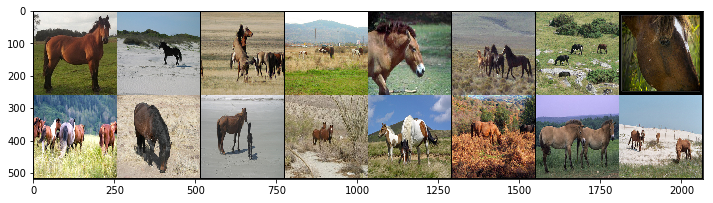

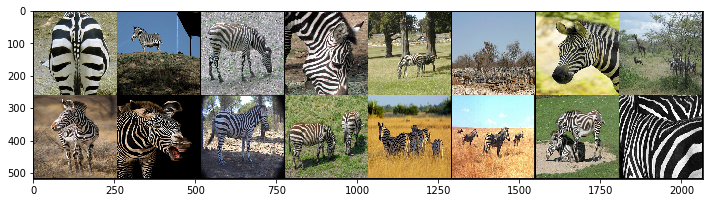

In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(dataloader_X) #반복되는 객체
images, _ = dataiter.next()  #first batch # the "_" is a placeholder for no labels

fig = plt.figure(figsize=(12, 8))  
imshow(torchvision.utils.make_grid(images))

dataiter = iter(dataloader_Y)
images, _ = dataiter.next()
# show images
fig = plt.figure(figsize=(12, 8))  
imshow(torchvision.utils.make_grid(images))

In [5]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(1.)


In [6]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-255.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(1.)


---
# 2. Define the Model

## (1) function for Discriminator

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

## (2) Discriminator

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))      #결과 size [16, 64, 64, 64]
        out = F.relu(self.conv2(out))    #[16, 128, 32, 32]
        out = F.relu(self.conv3(out))    #[16, 256, 16, 16]
        out = F.relu(self.conv4(out))    #[16, 512, 8, 8]
        out = self.conv5(out)            #[16, 1, 7, 7]
        return out

## (3) functions/class of Generators

In [10]:
# residual block class
class ResidualBlock(nn.Module):

    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
            
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)
    

## (4) Generator Architecture

In [11]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # Encoder 
        
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # Resnet part
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Decoder
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)  # no batch norm on last layer
        
    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.tanh(self.deconv3(out))           # tanh applied to last layer

        return out

## (5) Create Model

In [12]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    if torch.cuda.is_available():   # move models to GPU, if available
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [13]:
G_XtoY, G_YtoX, D_X, D_Y = create_model()  # call the function to get models

Models moved to GPU.


# 3. Loss

In [14]:
def real_mse_loss(D_out):
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return lambda_weight*reconstr_loss    


# 4. Optimizers

In [15]:
import torch.optim as optim

# hyperparams for Adam optimizer #gradient의 지수평균 이용
lr=0.0002
beta1=0.5
beta2=0.999 # default value

d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])


# 5. Training

In [16]:
# import from other code
from help import save_samples, checkpoint
import time

In [17]:
# train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    since = time.time()
    print_every=100
    
    losses = []      # keep track of losses over time

    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        # 1. D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            time_elapsed = time.time() - since
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f} time : {:.0f}m {:.0f}s'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item(),time_elapsed // 60, time_elapsed % 60))


        sample_every=200
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples3_cyclegan')
            G_YtoX.train()
            G_XtoY.train()


                    # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [18]:
n_epochs = 6000 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

torch.save(D_X.state_dict(),'D_X2.pt')
torch.save(D_Y.state_dict(),'D_Y2.pt')
torch.save(G_XtoY.state_dict(),'D_XtoY2.pt')
torch.save(G_YtoX.state_dict(),'D_YtoX2.pt')

Epoch [  100/ 6000] | d_X_loss: 0.3573 | d_Y_loss: 0.3111 | g_total_loss: 5.6671 time : 1m 29s
Epoch [  200/ 6000] | d_X_loss: 0.4275 | d_Y_loss: 0.3691 | g_total_loss: 5.6223 time : 2m 58s
Saved samples3_cyclegan/sample-000200-X-Y.png
Saved samples3_cyclegan/sample-000200-Y-X.png
Epoch [  300/ 6000] | d_X_loss: 0.4015 | d_Y_loss: 0.1698 | g_total_loss: 5.5434 time : 4m 30s
Epoch [  400/ 6000] | d_X_loss: 0.3442 | d_Y_loss: 0.1748 | g_total_loss: 4.6794 time : 6m 1s
Saved samples3_cyclegan/sample-000400-X-Y.png
Saved samples3_cyclegan/sample-000400-Y-X.png
Epoch [  500/ 6000] | d_X_loss: 0.3347 | d_Y_loss: 0.2201 | g_total_loss: 6.0369 time : 7m 32s
Epoch [  600/ 6000] | d_X_loss: 0.3467 | d_Y_loss: 0.1748 | g_total_loss: 4.8054 time : 9m 3s
Saved samples3_cyclegan/sample-000600-X-Y.png
Saved samples3_cyclegan/sample-000600-Y-X.png
Epoch [  700/ 6000] | d_X_loss: 0.3045 | d_Y_loss: 0.3922 | g_total_loss: 4.4868 time : 10m 34s
Epoch [  800/ 6000] | d_X_loss: 0.4254 | d_Y_loss: 0.1925 | 

Epoch [ 5900/ 6000] | d_X_loss: 0.1939 | d_Y_loss: 0.1710 | g_total_loss: 5.0443 time : 89m 51s
Epoch [ 6000/ 6000] | d_X_loss: 0.2659 | d_Y_loss: 0.1534 | g_total_loss: 3.9757 time : 91m 24s
Saved samples3_cyclegan/sample-006000-X-Y.png
Saved samples3_cyclegan/sample-006000-Y-X.png


# 6. Evaluate the Result with Pretrained model

In [19]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


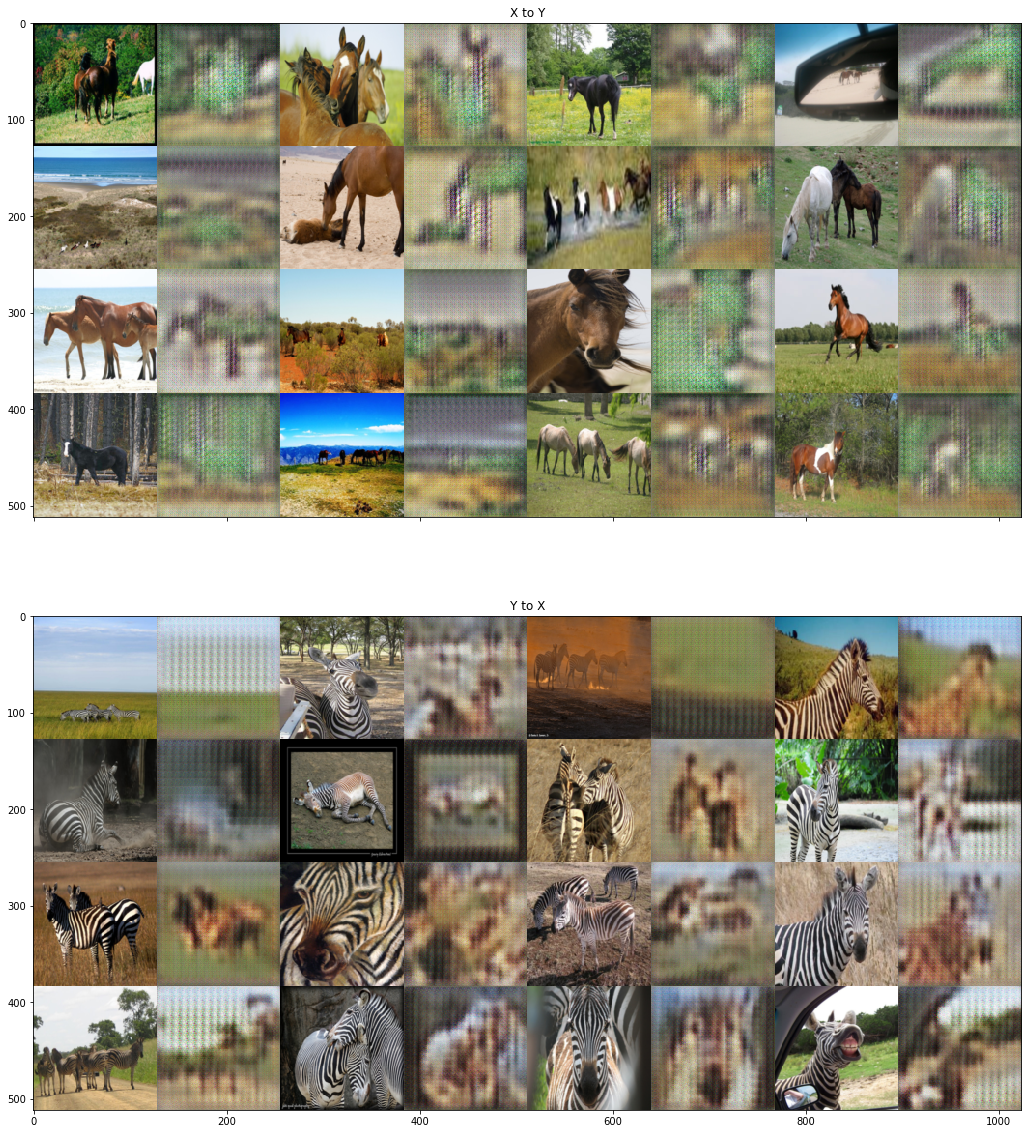

In [20]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

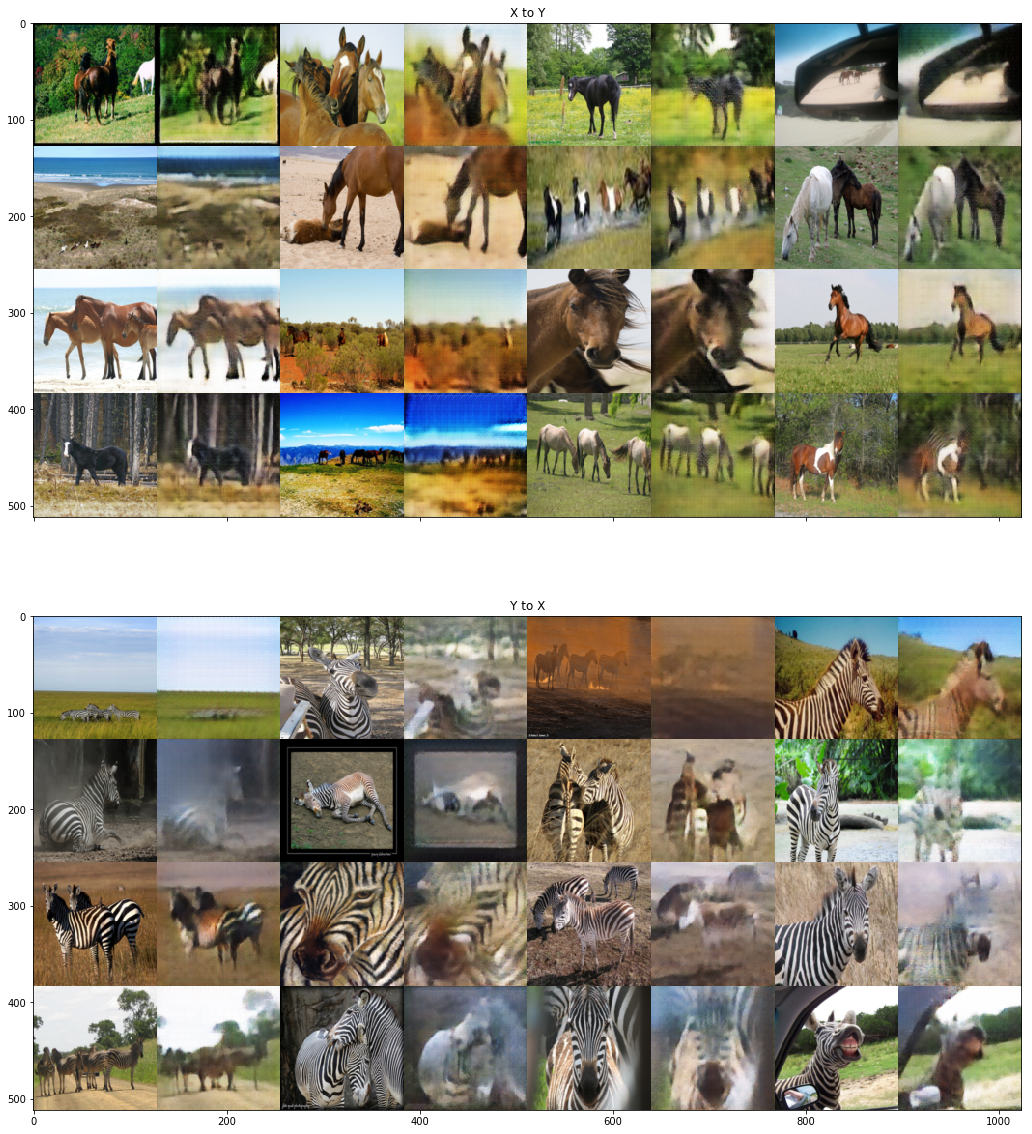

In [21]:
# view samples at iteration 4000
view_samples(4000, 'samples_cyclegan')

reference : https://github.com/udacity/deep-learning-v2-pytorch